In [12]:
import pandas as pd
import os
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from models.EmoTimeBert import EmotionalTimeBert
from sklearn.metrics import f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from data_handling.datasets.EmpatheticDialogues import EmpatheticDialoguesDataset
from utils.utils import train_model, validate_model, test_model, collate_conversations
os.environ["TOKENIZERS_PARALLELISM"] = "false"
TRAINING = True


In [13]:
full_empath_data = load_dataset("facebook/empathetic_dialogues", trust_remote_code=True)
empath_data = full_empath_data["train"].to_pandas() #pd.read_csv("empatheticdialogues/train.csv", on_bad_lines="skip")
val_empath_data = full_empath_data["validation"].to_pandas()#pd.read_csv("empatheticdialogues/valid.csv", on_bad_lines="skip")
grouped = empath_data.groupby("conv_id")
val_grouped = val_empath_data.groupby("conv_id")
# speaker_counts = (
#     empath_data
#     .groupby("conv_id")["speaker_idx"]
#     .nunique()
# )
# speaker_counts.value_counts()

In [14]:
emotion_labels = empath_data["context"].unique().tolist()
emotion_to_id = {emotion: idx for idx, emotion in enumerate(emotion_labels)}

conversations = []

for conv_id, df_conv in grouped:
    texts = df_conv["utterance"].tolist()
    # texts = (df_conv["prompt"] + "[SEP]" + df_conv["utterance"]).tolist()
    labels = [emotion_to_id[x] for x in df_conv["context"]]
    timestamps = df_conv["utterance_idx"].tolist()
    speakers = (
        df_conv["speaker_idx"]
        .rank(method="dense")
        .astype(int)
        .sub(1)
        .tolist()
    )
    conversations.append({
        "texts": texts,
        "labels": labels,
        "timestamps": timestamps,
        "speakers": speakers
    })

val_conversations = []

for conv_id, df_conv in val_grouped:
    texts = df_conv["utterance"].tolist()
    # texts = (df_conv["prompt"] + "[SEP]" + df_conv["utterance"]).tolist()
    labels = [emotion_to_id[x] for x in df_conv["context"]]
    timestamps = df_conv["utterance_idx"].tolist()
    speakers = (
        df_conv["speaker_idx"]
        .rank(method="dense")
        .astype(int)
        .sub(1)
        .tolist()
    )
    val_conversations.append({
        "texts": texts,
        "labels": labels,
        "timestamps": timestamps,
        "speakers": speakers
    })


In [15]:

# texts = (empath_data["prompt"].astype(str) + "[SEP]" + empath_data["utterance"].astype(str)).tolist()
# raw_labels = empath_data["context"].values.tolist()
# labels = [emotion_to_id[label] for label in raw_labels]
# time_stamps = empath_data["utterance_idx"].values.tolist()

In [16]:
# Dataset class moved to data_handling/datasets/EmpatheticDialogues.py


In [17]:
# collate_conversations moved to utils/utils.py


In [18]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
dataset = EmpatheticDialoguesDataset(conversations, tokenizer)
val_dataset = EmpatheticDialoguesDataset(val_conversations, tokenizer)
loader = DataLoader(
    dataset,
    batch_size=40,
    shuffle=True,
    num_workers=8,
    # pin_memory=True,
    # persistent_workers=True,
    collate_fn=lambda x: collate_conversations(x, tokenizer),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=40,
    shuffle=False, # future me, keep it false, helps reproduce results
    num_workers=8,
    #pin_memory=True,
    # persistent_workers=True,
    collate_fn=lambda x: collate_conversations(x, tokenizer),
)


In [19]:
# TemporalTransformer moved to models/TemporalTransformer.py


In [20]:
# EmotionalTimeBert moved to models/EmoTimeBert.py


In [21]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
    print("Device:", torch.cuda.get_device_name(0))
    print("CUDA Enabled!")

model = EmotionalTimeBert("./medbert_4_epochs", num_labels=len(emotion_labels)).to(device)

if not TRAINING:
    model.load_state_dict(torch.load("Checkpoints/Old.pt")) #  emotional_time_bert_GRU_To_Show5.pt"

criterion = nn.CrossEntropyLoss(ignore_index=-1)

optimizer = torch.optim.AdamW([
    {"params": model.encoder.encoder.layer[-2:].parameters(), "lr": 1e-5},
    {"params": model.temporal_transformer.parameters(), "lr": 3e-4},
    {"params": model.time_embed.parameters(), "lr": 3e-4},
    {"params": model.speakers_embed.parameters(), "lr": 3e-4},
    {"params": model.head_emotions.parameters(), "lr": 3e-4},
])

Device: NVIDIA GeForce RTX 5080
CUDA Enabled!


In [23]:
train_step_losses = []
val_step_losses = []
global_steps = []
val_steps = []


if TRAINING:
    num_of_epochs = 5
    step = 0
    for epoch in range(num_of_epochs):
        progress_bar = tqdm(loader, total=len(loader))
        avg_loss, step = train_model(model, optimizer, device, criterion=criterion, bar=progress_bar, train_step_losses=train_step_losses, global_steps=global_steps, start_step=step)
        validate_progress = tqdm(val_loader, total=len(val_loader))
        val_loss, val_f1, step = validate_model(model, device, criterion=criterion, bar=validate_progress, val_step_losses=val_step_losses, val_steps=val_steps, start_step=step)

        print(f"Epoch {epoch+1}: train loss = {avg_loss:.4f}")
        print(f"Epoch {epoch+1}: val loss   = {val_loss:.4f}")
        print(f"Epoch {epoch+1}: val F1     = {val_f1:.4f}")

    torch.save(model.state_dict(), f"Checkpoints/NewModel.pt")



Epoch 5: train loss = 1.6126
Epoch 5: val loss   = 1.7685
Epoch 5: val F1     = 0.4393


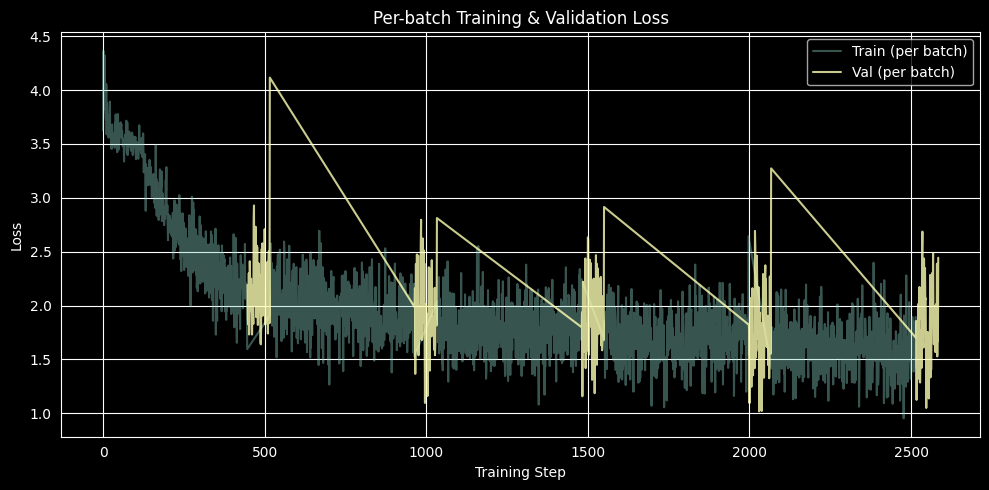

In [24]:
if TRAINING:
    plt.figure(figsize=(10, 5))
    plt.plot(global_steps, train_step_losses, alpha=0.4, label="Train (per batch)")
    plt.plot(val_steps, val_step_losses, alpha=0.8, label="Val (per batch)")

    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title("Per-batch Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

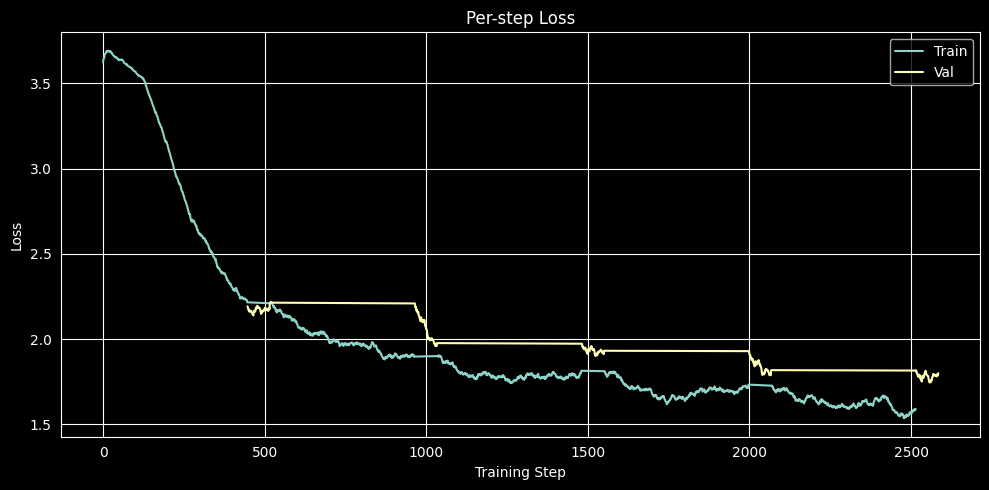

In [25]:
def ema(values, beta=0.98):
    smoothed = []
    avg = values[0]
    for v in values:
        avg = beta * avg + (1 - beta) * v
        smoothed.append(avg)
    return smoothed

if TRAINING:
    plt.figure(figsize=(10, 5))
    plt.plot(global_steps, ema(train_step_losses), label="Train")
    plt.plot(val_steps, ema(val_step_losses), label="Val")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title("Per-step Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [26]:
test_empath_data = full_empath_data["test"].to_pandas()
test_grouped = test_empath_data.groupby("conv_id")
test_conversations = []

for conv_id, df_conv in test_grouped:
    texts = df_conv["utterance"].tolist()
    # texts = (df_conv["prompt"] + "[SEP]" + df_conv["utterance"]).tolist()
    labels = [emotion_to_id[x] for x in df_conv["context"]]
    timestamps = df_conv["utterance_idx"].tolist()
    speakers = (
        df_conv["speaker_idx"]
        .rank(method="dense")
        .astype(int)
        .sub(1)
        .tolist()
    )

    test_conversations.append({
        "texts": texts,
        "labels": labels,
        "timestamps": timestamps,
        "speakers": speakers
    })

In [27]:
for conv_id, df_conv in test_grouped:
    print(conv_id)
    print(df_conv)
    break

hit:0_conv:0
        conv_id  utterance_idx context  \
0  hit:0_conv:0              1  guilty   
1  hit:0_conv:0              2  guilty   
2  hit:0_conv:0              3  guilty   
3  hit:0_conv:0              4  guilty   
4  hit:0_conv:0              5  guilty   

                                              prompt  speaker_idx  \
0  I felt guilty when I was driving home one nigh...            0   
1  I felt guilty when I was driving home one nigh...            1   
2  I felt guilty when I was driving home one nigh...            0   
3  I felt guilty when I was driving home one nigh...            1   
4  I felt guilty when I was driving home one nigh...            0   

                                           utterance     selfeval tags  
0  Yeah about 10 years ago I had a horrifying exp...  2|2|5_5|5|5       
1                       Did you suffer any injuries?  2|2|5_5|5|5       
2  No I wasn't hit. It turned out they were drunk...  2|2|5_5|5|5       
3  Why did you feel guilty?

In [28]:
test_dataset = EmpatheticDialoguesDataset(test_conversations, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=8,
    collate_fn=lambda x: collate_conversations(x, tokenizer)
)

In [29]:
test_f1 = test_model(
    model=model,
    dataloader=test_loader,
    device=device,
    emotion_labels=emotion_labels
)

# also look into bert's special keywords

In [30]:

def ablation(model, dataloader, device, ablate):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            utterance_mask = batch["utterance_mask"].to(device)

            timestamps = batch["timestamps"].to(device)
            speakers = batch["speakers"].to(device)

            if ablate == "time_zero":
                timestamps = torch.zeros_like(timestamps)
            elif ablate == "time_shuffle":
                timestamps = timestamps[torch.randperm(timestamps.size(0))]
            elif ablate == "speaker_zero":
                speakers = torch.zeros_like(speakers)

            logits = model(
                input_ids, attention_mask,
                timestamps, speakers,
                labels, utterance_mask
            )

            preds = logits.argmax(-1)
            mask = labels != -1

            all_preds.append(preds[mask].cpu())
            all_labels.append(labels[mask].cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return f1_score(all_labels, all_preds, average="macro")

print("Normal:", ablation(model, val_loader, device, "none"))
print("Time zero:", ablation(model, val_loader, device, "time_zero"))
print("Time shuffle:", ablation(model, val_loader, device, "time_shuffle"))
print("Speaker zero:", ablation(model, val_loader, device, "speaker_zero"))


Speaker zero: 0.4353576376309064
